In [58]:
import wandb

wandb.login()
wandb.init(project="COCO_data")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_iou,█▆▇▇▇▇▅▇▆▄▆▆▆▆▃▁▆▆▆▆
epoch,20
train_loss,0.07552
val_iou,0.56943


# train val split

In [ ]:
import os
import shutil
import random

# Config
image_src = "/home/ravindra/VJ_technology/images/val2017"
mask_src = "/home/ravindra/VJ_technology/code/masks_raw_new"

image_dst = "data/images"
mask_dst = "data/masks"
train_ratio = 0.8

# Prepare folders
for split in ['train', 'val']:
    os.makedirs(os.path.join(image_dst, split), exist_ok=True)
    os.makedirs(os.path.join(mask_dst, split), exist_ok=True)

# Get all filenames
image_files = sorted([f for f in os.listdir(image_src) if f.endswith('.jpg')])
random.shuffle(image_files)

split_idx = int(len(image_files) * train_ratio)
train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

# Copy files
for split, files in zip(['train', 'val'], [train_files, val_files]):
    for file in files:
        shutil.copy(os.path.join(image_src, file), os.path.join(image_dst, split, file))
        mask_file = file.replace('.jpg', '.png')
        shutil.copy(os.path.join(mask_src, mask_file), os.path.join(mask_dst, split, mask_file))

print("✅ Dataset split complete.")


✅ Dataset split complete.


In [59]:
from torch.utils.data import Dataset
import os
import cv2
import numpy as np
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.transform = transform
# class SegmentationDataset(Dataset):
#     def __init__(self, image_dir, mask_dir, transform=None, file_list=None):
#         self.image_dir = image_dir
#         self.mask_dir = mask_dir
#         self.image_files = sorted(os.listdir(image_dir)) if file_list is None else file_list
#         self.mask_files = [f.replace('.jpg', '.png') for f in self.image_files]
#         self.transform = transform


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # shape: (H, W), values = class indices

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask.long()
    

# transformation

def get_transform():
    return A.Compose([
        A.Resize(256, 256),
        A.Normalize(),
        ToTensorV2()
    ])


In [60]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        self.down1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.up_block3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up_block2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up_block1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))

        bn = self.bottleneck(self.pool3(d3))

        u3 = self.up_block3(torch.cat([self.up3(bn), d3], dim=1))
        u2 = self.up_block2(torch.cat([self.up2(u3), d2], dim=1))
        u1 = self.up_block1(torch.cat([self.up1(u2), d1], dim=1))

        return self.final(u1)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# from dataset import SegmentationDataset, get_transform
# from model import UNet

# === CONFIG ===
NUM_CLASSES = 5  # 4 classes + 0 for background
EPOCHS = 25
BATCH_SIZE = 8
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

train_dataset = SegmentationDataset(
    image_dir="data/images/train",
    mask_dir="data/masks/train",
    transform=get_transform()
)

val_dataset = SegmentationDataset(
    image_dir="data/images/val",
    mask_dir="data/masks/val",
    transform=get_transform()
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

model = UNet(num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

def compute_iou(preds, labels):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(1, NUM_CLASSES):  # skip background
        pred_cls = preds == cls
        label_cls = labels == cls
        intersection = (pred_cls & label_cls).sum().item()
        union = (pred_cls | label_cls).sum().item()
        if union == 0:
            ious.append(1.0)
        else:
            ious.append(intersection / union)
    return sum(ious) / len(ious)

# === Training Loop ===
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # === Validation ===
    model.eval()
    val_iou = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            val_iou += compute_iou(outputs, masks)

    val_iou /= len(val_loader)
    
    # === Logging to wandb ===
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_loss,
        "val_iou": val_iou
    })

    print(f"[Epoch {epoch+1}] Train Loss: {avg_loss:.4f} | Val IoU: {val_iou:.4f}")

# === Save Final Model ===
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), "checkpoints/unet_coco.pt")
print("✅ Training complete. Model saved.")


Epoch 1/25: 100%|██████████| 500/500 [00:26<00:00, 19.23it/s]


[Epoch 1] Train Loss: 0.7556 | Val IoU: 0.3142


Epoch 2/25: 100%|██████████| 500/500 [00:30<00:00, 16.32it/s]


[Epoch 2] Train Loss: 0.5081 | Val IoU: 0.3363


Epoch 3/25: 100%|██████████| 500/500 [00:30<00:00, 16.38it/s]


[Epoch 3] Train Loss: 0.4686 | Val IoU: 0.3280


Epoch 4/25: 100%|██████████| 500/500 [00:30<00:00, 16.55it/s]


[Epoch 4] Train Loss: 0.4494 | Val IoU: 0.3157


Epoch 5/25: 100%|██████████| 500/500 [00:30<00:00, 16.39it/s]


[Epoch 5] Train Loss: 0.4409 | Val IoU: 0.3389


Epoch 6/25: 100%|██████████| 500/500 [00:30<00:00, 16.28it/s]


[Epoch 6] Train Loss: 0.4329 | Val IoU: 0.3637


Epoch 7/25: 100%|██████████| 500/500 [00:29<00:00, 17.05it/s]


[Epoch 7] Train Loss: 0.4249 | Val IoU: 0.3612


Epoch 8/25: 100%|██████████| 500/500 [00:31<00:00, 16.11it/s]


[Epoch 8] Train Loss: 0.4202 | Val IoU: 0.3762


Epoch 9/25: 100%|██████████| 500/500 [00:30<00:00, 16.44it/s]


[Epoch 9] Train Loss: 0.4144 | Val IoU: 0.3372


Epoch 10/25: 100%|██████████| 500/500 [00:30<00:00, 16.36it/s]


[Epoch 10] Train Loss: 0.4083 | Val IoU: 0.3588


Epoch 11/25: 100%|██████████| 500/500 [00:30<00:00, 16.49it/s]


[Epoch 11] Train Loss: 0.4037 | Val IoU: 0.3696


Epoch 12/25: 100%|██████████| 500/500 [00:30<00:00, 16.57it/s]


[Epoch 12] Train Loss: 0.3994 | Val IoU: 0.3894


Epoch 13/25: 100%|██████████| 500/500 [00:29<00:00, 17.16it/s]


[Epoch 13] Train Loss: 0.3954 | Val IoU: 0.3593


Epoch 14/25: 100%|██████████| 500/500 [00:30<00:00, 16.32it/s]


[Epoch 14] Train Loss: 0.3902 | Val IoU: 0.3686


Epoch 15/25: 100%|██████████| 500/500 [00:30<00:00, 16.45it/s]


[Epoch 15] Train Loss: 0.3851 | Val IoU: 0.3698


Epoch 16/25: 100%|██████████| 500/500 [00:30<00:00, 16.59it/s]


[Epoch 16] Train Loss: 0.3814 | Val IoU: 0.3867


Epoch 17/25: 100%|██████████| 500/500 [00:30<00:00, 16.37it/s]


[Epoch 17] Train Loss: 0.3796 | Val IoU: 0.3794


Epoch 18/25: 100%|██████████| 500/500 [00:30<00:00, 16.16it/s]


[Epoch 18] Train Loss: 0.3702 | Val IoU: 0.3753


Epoch 19/25: 100%|██████████| 500/500 [00:29<00:00, 16.93it/s]


[Epoch 19] Train Loss: 0.3661 | Val IoU: 0.3981


Epoch 20/25: 100%|██████████| 500/500 [00:30<00:00, 16.42it/s]


[Epoch 20] Train Loss: 0.3612 | Val IoU: 0.3860


Epoch 21/25: 100%|██████████| 500/500 [00:30<00:00, 16.34it/s]


[Epoch 21] Train Loss: 0.3593 | Val IoU: 0.3854


Epoch 22/25: 100%|██████████| 500/500 [00:30<00:00, 16.39it/s]


[Epoch 22] Train Loss: 0.3521 | Val IoU: 0.3949


Epoch 23/25: 100%|██████████| 500/500 [00:30<00:00, 16.32it/s]


[Epoch 23] Train Loss: 0.3510 | Val IoU: 0.3895


Epoch 24/25: 100%|██████████| 500/500 [00:30<00:00, 16.33it/s]


[Epoch 24] Train Loss: 0.3460 | Val IoU: 0.3682


Epoch 25/25: 100%|██████████| 500/500 [00:29<00:00, 16.87it/s]


[Epoch 25] Train Loss: 0.3394 | Val IoU: 0.4025
✅ Training complete. Model saved.


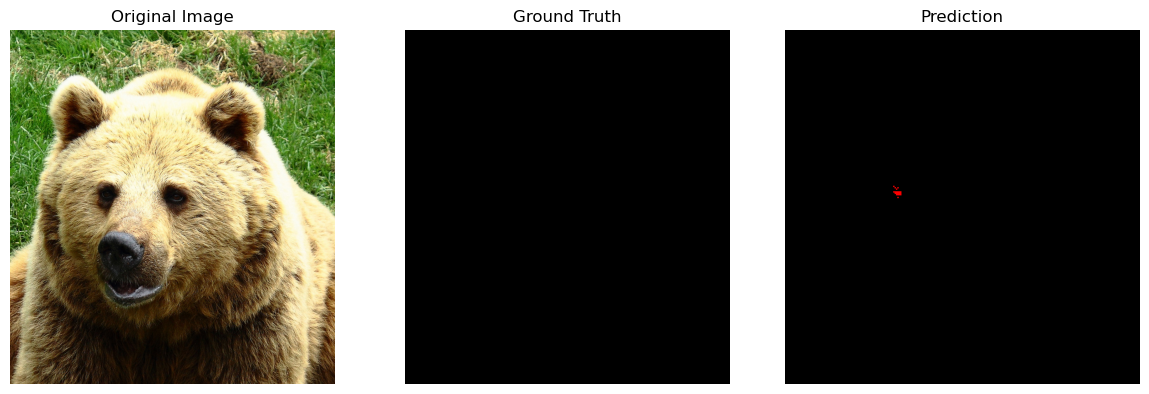

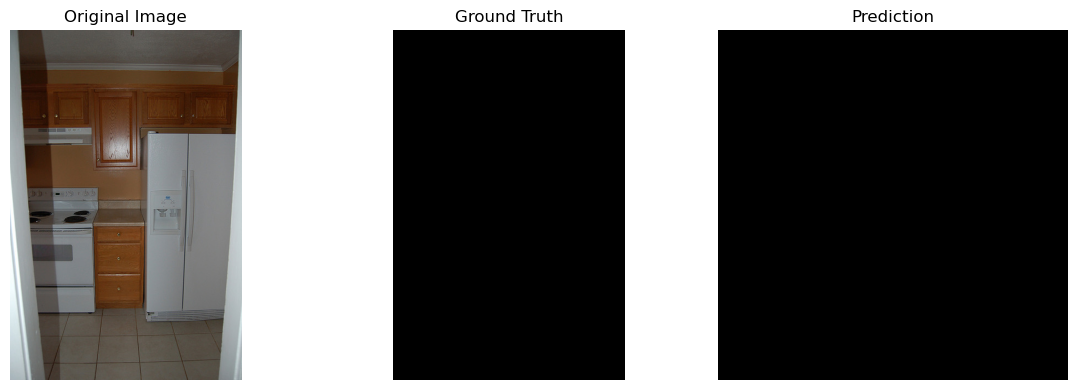

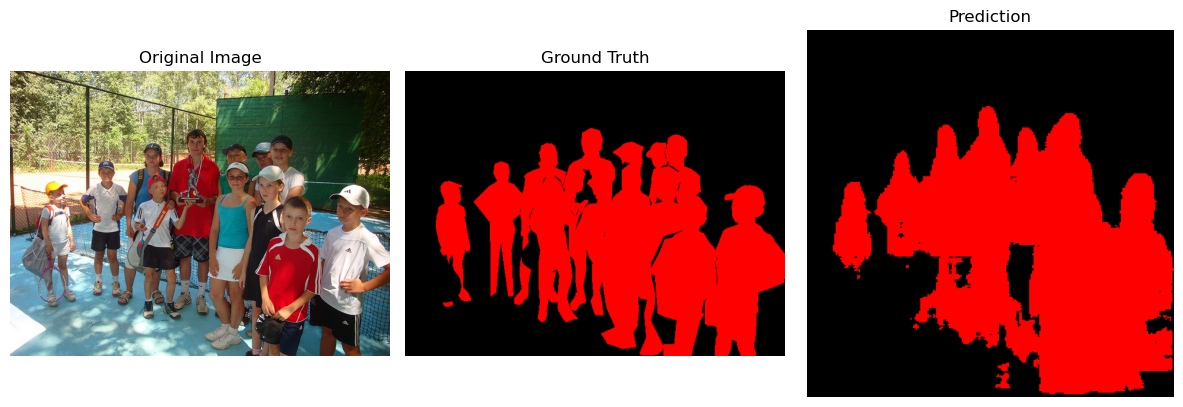

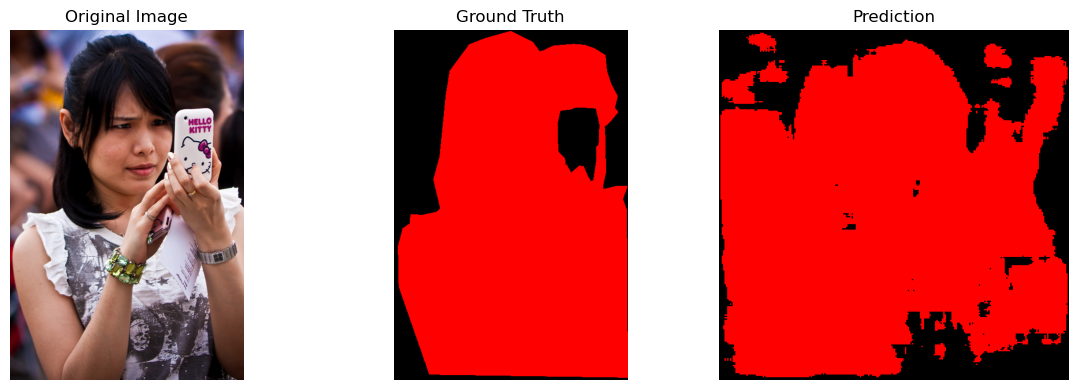

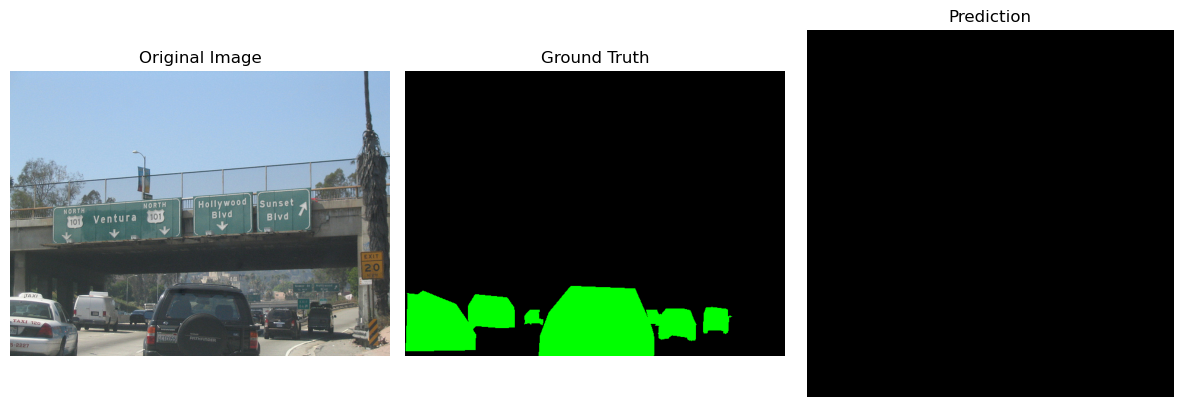

In [71]:
import torch
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from model import UNet
# from dataset import get_transform

# === CONFIG ===
model_path = "checkpoints/unet_coco_5.pt"
image_dir = "data/images/val"
mask_dir = "data/masks/val"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 5

# Class colors (same as training)
class_colors = {
    0: (0, 0, 0),           
    1: (255, 0, 0),         
    2: (0, 255, 0),         
    3: (0, 0, 255),      
    4: (255, 255, 0)     
}


# === Load model ===
model = UNet(num_classes=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()

# === Visualization function ===
def decode_mask(mask):
    """Convert class mask to RGB image."""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id, color in class_colors.items():
        color_mask[mask == cls_id] = color
    return color_mask

# === Run on few samples ===
sample_files = sorted(os.listdir(image_dir))[:5]

transform = get_transform()

for file in sample_files:
    image_path = os.path.join(image_dir, file)
    mask_path = os.path.join(mask_dir, file.replace(".jpg", ".png"))

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask_gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Transform and predict
    transformed = transform(image=image_rgb, mask=mask_gt)
    img_tensor = transformed['image'].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(img_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Visuals
    mask_pred_colored = decode_mask(pred_mask)
    mask_gt_colored = decode_mask(mask_gt)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask_gt_colored)
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(mask_pred_colored)
    plt.title("Prediction")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [53]:
import torch

def compute_class_iou(preds, labels, num_classes=5):
    """
    Calculates per-class IoU and mean IoU.

    Args:
        preds: [N, C, H, W] logits (from model)
        labels: [N, H, W] ground truth mask (class indices)
        num_classes: total number of classes (including background)

    Returns:
        iou_per_class: dict of class-wise IoU
        mean_iou: average IoU across all classes (excluding empty ones)
    """
    preds = torch.argmax(preds, dim=1)  # [N, H, W]
    iou_per_class = {}
    iou_sum = 0
    valid_classes = 0

    for cls in range(num_classes):
        pred_cls = (preds == cls)
        label_cls = (labels == cls)

        intersection = (pred_cls & label_cls).sum().item()
        union = (pred_cls | label_cls).sum().item()

        if union == 0:
            iou_per_class[cls] = None  # Class not present in batch
        else:
            iou = intersection / union
            iou_per_class[cls] = iou
            iou_sum += iou
            valid_classes += 1

    mean_iou = iou_sum / valid_classes if valid_classes > 0 else 0.0
    return iou_per_class, mean_iou

# === IoU Evaluation (U-Net version) ===
model.eval()
iou_totals = {cls: [] for cls in range(NUM_CLASSES)}

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        outputs = model(images)  # ✅ No ["out"] for U-Net

        class_iou, _ = compute_class_iou(outputs, masks, num_classes=NUM_CLASSES)
        for cls, iou in class_iou.items():
            if iou is not None:
                iou_totals[cls].append(iou)

# === Print Class-wise IoU ===
print("\n🔍 Class-wise IoU (U-Net):")
for cls in range(NUM_CLASSES):
    if iou_totals[cls]:
        avg = sum(iou_totals[cls]) / len(iou_totals[cls])
        print(f"Class {cls}: IoU = {avg:.4f}")
    else:
        print(f"Class {cls}: Not present in validation set")



🔍 Class-wise IoU (U-Net):
Class 0: IoU = 0.8980
Class 1: IoU = 0.3620
Class 2: IoU = 0.0000
Class 3: IoU = 0.0000
Class 4: IoU = 0.0003


# finetuning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm
# from dataset import SegmentationDataset, get_transform

# === CONFIG ===
NUM_CLASSES = 5
BATCH_SIZE = 4
EPOCHS = 20
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# === Dataset ===
train_dataset = SegmentationDataset("data/images/train", "data/masks/train", get_transform())
val_dataset = SegmentationDataset("data/images/val", "data/masks/val", get_transform())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# === Load Pretrained DeepLabV3 ===
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model = model.to(DEVICE)

# === Loss and Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# === IoU Metric ===
def compute_iou(preds, labels):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(1, NUM_CLASSES):
        pred_cls = preds == cls
        label_cls = labels == cls
        intersection = (pred_cls & label_cls).sum().item()
        union = (pred_cls | label_cls).sum().item()
        if union == 0:
            ious.append(1.0)
        else:
            ious.append(intersection / union)
    return sum(ious) / len(ious)

# === Training Loop ===
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, masks in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{EPOCHS}]"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        outputs = model(images)["out"]
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # === Validation ===
    model.eval()
    val_iou = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)["out"]
            val_iou += compute_iou(outputs, masks)

    val_iou /= len(val_loader)

    # === Logging to wandb ===
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_loss,
        "val_iou": val_iou
    })

    print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Val IoU = {val_iou:.4f}")

# === Save Model ===
torch.save(model.state_dict(), "checkpoints/deeplabv3_coco_finetuned.pt")
print("✅ Model saved.")


In [68]:
import torch

checkpoint_path = "/home/ravindra/VJ_technology/code/checkpoints/deeplabv3_coco_finetuned.pt"
model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))

model.eval()

def compute_class_iou(preds, labels, num_classes=5):
    """
    Calculates per-class IoU and mean IoU.

    Args:
        preds: [N, C, H, W] logits (from model)
        labels: [N, H, W] ground truth mask (class indices)
        num_classes: total number of classes (including background)

    Returns:
        iou_per_class: dict of class-wise IoU
        mean_iou: average IoU across all classes (excluding empty ones)
    """
    preds = torch.argmax(preds, dim=1)  # [N, H, W]
    iou_per_class = {}
    iou_sum = 0
    valid_classes = 0

    for cls in range(num_classes):
        pred_cls = (preds == cls)
        label_cls = (labels == cls)

        intersection = (pred_cls & label_cls).sum().item()
        union = (pred_cls | label_cls).sum().item()

        if union == 0:
            iou_per_class[cls] = None  # Class not present in batch
        else:
            iou = intersection / union
            iou_per_class[cls] = iou
            iou_sum += iou
            valid_classes += 1

    mean_iou = iou_sum / valid_classes if valid_classes > 0 else 0.0
    return iou_per_class, mean_iou

model.eval()
iou_totals = {cls: [] for cls in range(NUM_CLASSES)}

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        outputs = model(images)["out"]

        class_iou, _ = compute_class_iou(outputs, masks, num_classes=NUM_CLASSES)
        for cls, iou in class_iou.items():
            if iou is not None:
                iou_totals[cls].append(iou)

# Final report
print("\n🔍 Class-wise IoU:")
for cls in range(NUM_CLASSES):
    if iou_totals[cls]:
        avg = sum(iou_totals[cls]) / len(iou_totals[cls])
        print(f"Class {cls}: IoU = {avg:.4f}")
    else:
        print(f"Class {cls}: Not present in validation set")



🔍 Class-wise IoU:
Class 0: IoU = 0.9364
Class 1: IoU = 0.5739
Class 2: IoU = 0.1814
Class 3: IoU = 0.2083
Class 4: IoU = 0.0792


# class weight

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm
# from dataset import SegmentationDataset, get_transform  # your existing dataset loader

# === CONFIG ===
NUM_CLASSES = 5  # background, person, car, bus, dog
BATCH_SIZE = 4
EPOCHS = 20
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# === Dataset ===
train_dataset = SegmentationDataset("data_new/images/train", "data_new/masks/train", get_transform())
val_dataset = SegmentationDataset("data_new/images/val", "data_new/masks/val", get_transform())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# === Load Pretrained DeepLabV3 ===
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model = model.to(DEVICE)

# === Class Weights (from pixel analysis)
# Pixel-based weights with background set low manually
class_weights = torch.tensor([
    0.01,      # background
    0.0228,    # person
    0.3579,    # car
    0.2390,    # bus
    0.3803     # dog
], dtype=torch.float32).to(DEVICE)

# === Loss and Optimizer ===
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)

# === IoU Metric ===
def compute_iou(preds, labels):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(1, NUM_CLASSES):  # Skip background
        pred_cls = preds == cls
        label_cls = labels == cls
        intersection = (pred_cls & label_cls).sum().item()
        union = (pred_cls | label_cls).sum().item()
        if union == 0:
            ious.append(1.0)  # If no ground truth, consider it perfect
        else:
            ious.append(intersection / union)
    return sum(ious) / len(ious)

# === Training Loop ===
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, masks in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{EPOCHS}]"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        outputs = model(images)["out"]
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # === Validation ===
    model.eval()
    val_iou = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)["out"]
            val_iou += compute_iou(outputs, masks)

    val_iou /= len(val_loader)

    # === Logging to wandb ===
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_loss,
        "val_iou": val_iou
    })

    print(f"[Epoch {epoch+1}] Train Loss: {avg_loss:.4f} | Val IoU: {val_iou:.4f}")

# === Save Model ===
torch.save(model.state_dict(), "checkpoints/deeplabv3_coco_weighted_5.pt")
print("✅ Training complete. Model saved.")


[Epoch 1/20]: 100%|██████████| 1000/1000 [00:40<00:00, 24.67it/s]


[Epoch 1] Train Loss: 0.7265 | Val IoU: 0.3544


[Epoch 2/20]: 100%|██████████| 1000/1000 [00:38<00:00, 25.71it/s]


[Epoch 2] Train Loss: 0.5224 | Val IoU: 0.4060


[Epoch 3/20]: 100%|██████████| 1000/1000 [00:39<00:00, 25.13it/s]


[Epoch 3] Train Loss: 0.4577 | Val IoU: 0.3674


[Epoch 4/20]: 100%|██████████| 1000/1000 [00:40<00:00, 24.40it/s]


[Epoch 4] Train Loss: 0.3971 | Val IoU: 0.4075


[Epoch 5/20]: 100%|██████████| 1000/1000 [00:42<00:00, 23.77it/s]


[Epoch 5] Train Loss: 0.3268 | Val IoU: 0.2774


[Epoch 6/20]: 100%|██████████| 1000/1000 [00:40<00:00, 24.51it/s]


[Epoch 6] Train Loss: 0.2877 | Val IoU: 0.4944


[Epoch 7/20]: 100%|██████████| 1000/1000 [00:40<00:00, 24.97it/s]


[Epoch 7] Train Loss: 0.2496 | Val IoU: 0.5159


[Epoch 8/20]: 100%|██████████| 1000/1000 [00:41<00:00, 24.20it/s]


[Epoch 8] Train Loss: 0.2194 | Val IoU: 0.5299


[Epoch 9/20]: 100%|██████████| 1000/1000 [00:40<00:00, 24.54it/s]


[Epoch 9] Train Loss: 0.1964 | Val IoU: 0.6037


[Epoch 10/20]: 100%|██████████| 1000/1000 [00:40<00:00, 24.43it/s]


[Epoch 10] Train Loss: 0.1773 | Val IoU: 0.4590


[Epoch 11/20]: 100%|██████████| 1000/1000 [00:40<00:00, 24.59it/s]


[Epoch 11] Train Loss: 0.1475 | Val IoU: 0.5735


[Epoch 12/20]: 100%|██████████| 1000/1000 [00:40<00:00, 24.62it/s]


[Epoch 12] Train Loss: 0.1490 | Val IoU: 0.4314


[Epoch 13/20]: 100%|██████████| 1000/1000 [00:39<00:00, 25.59it/s]


[Epoch 13] Train Loss: 0.1881 | Val IoU: 0.4821


[Epoch 14/20]: 100%|██████████| 1000/1000 [00:40<00:00, 24.47it/s]


[Epoch 14] Train Loss: 0.1247 | Val IoU: 0.5856


[Epoch 15/20]: 100%|██████████| 1000/1000 [00:40<00:00, 24.71it/s]


[Epoch 15] Train Loss: 0.1495 | Val IoU: 0.5192


[Epoch 16/20]: 100%|██████████| 1000/1000 [00:41<00:00, 24.14it/s]


[Epoch 16] Train Loss: 0.1019 | Val IoU: 0.6278


[Epoch 17/20]: 100%|██████████| 1000/1000 [00:40<00:00, 24.81it/s]


[Epoch 17] Train Loss: 0.1589 | Val IoU: 0.5583


[Epoch 18/20]: 100%|██████████| 1000/1000 [00:41<00:00, 24.38it/s]


[Epoch 18] Train Loss: 0.1434 | Val IoU: 0.5889


[Epoch 19/20]: 100%|██████████| 1000/1000 [00:40<00:00, 24.54it/s]


[Epoch 19] Train Loss: 0.1172 | Val IoU: 0.6204


[Epoch 20/20]: 100%|██████████| 1000/1000 [00:40<00:00, 24.89it/s]


[Epoch 20] Train Loss: 0.0983 | Val IoU: 0.5959
✅ Training complete. Model saved.


In [16]:
import torch

def compute_class_iou(preds, labels, num_classes=5):
    """
    Calculates per-class IoU and mean IoU.

    Args:
        preds: [N, C, H, W] logits (from model)
        labels: [N, H, W] ground truth mask (class indices)
        num_classes: total number of classes (including background)

    Returns:
        iou_per_class: dict of class-wise IoU
        mean_iou: average IoU across all classes (excluding empty ones)
    """
    preds = torch.argmax(preds, dim=1)  # [N, H, W]
    iou_per_class = {}
    iou_sum = 0
    valid_classes = 0

    for cls in range(num_classes):
        pred_cls = (preds == cls)
        label_cls = (labels == cls)

        intersection = (pred_cls & label_cls).sum().item()
        union = (pred_cls | label_cls).sum().item()

        if union == 0:
            iou_per_class[cls] = None  # Class not present in batch
        else:
            iou = intersection / union
            iou_per_class[cls] = iou
            iou_sum += iou
            valid_classes += 1

    mean_iou = iou_sum / valid_classes if valid_classes > 0 else 0.0
    return iou_per_class, mean_iou

model.eval()
iou_totals = {cls: [] for cls in range(NUM_CLASSES)}

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        outputs = model(images)["out"]

        class_iou, _ = compute_class_iou(outputs, masks, num_classes=NUM_CLASSES)
        for cls, iou in class_iou.items():
            if iou is not None:
                iou_totals[cls].append(iou)

# Final report
print("\n🔍 Class-wise IoU:")
for cls in range(NUM_CLASSES):
    if iou_totals[cls]:
        avg = sum(iou_totals[cls]) / len(iou_totals[cls])
        print(f"Class {cls}: IoU = {avg:.4f}")
    else:
        print(f"Class {cls}: Not present in validation set")



🔍 Class-wise IoU:
Class 0: IoU = 0.9229
Class 1: IoU = 0.5642
Class 2: IoU = 0.1218
Class 3: IoU = 0.1469
Class 4: IoU = 0.0543


# oversampling

In [17]:
import os
import cv2
from tqdm import tqdm

mask_dir = "data/masks/train"
image_dir = "data/images/train"
all_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

rare_class_ids = [3, 4]  # bus, dog
rare_images = []

# Build a list of rare-class image files
for file in tqdm(all_files, desc="Checking masks for rare classes"):
    mask_path = os.path.join(mask_dir, file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if any(cls in mask for cls in rare_class_ids):
        rare_images.append(file)

print(f"🟠 Found {len(rare_images)} rare-class images.")


Checking masks for rare classes: 100%|██████████| 4000/4000 [00:05<00:00, 736.12it/s]

🟠 Found 280 rare-class images.


In [19]:
# Now mix: normal + duplicated rare-class files
oversampled_files = all_files + rare_images * 3  # tripling rare images

# Shuffle to prevent ordering bias
import random
random.shuffle(oversampled_files)

# Save this list or pass it to your Dataset class

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm
# from dataset import SegmentationDataset, get_transform  # your existing dataset loader

# === CONFIG ===
NUM_CLASSES = 5  # background, person, car, bus, dog
BATCH_SIZE = 4
EPOCHS = 20
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


oversampled_images = [f.replace('.png', '.jpg') for f in oversampled_files]

train_dataset = SegmentationDataset(
    image_dir="data/images/train",
    mask_dir="data/masks/train",
    transform=get_transform(),
    file_list=oversampled_images
)

val_dataset = SegmentationDataset("data/images/val", "data/masks/val", get_transform())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# === Load Pretrained DeepLabV3 ===
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model = model.to(DEVICE)

# === Class Weights (from pixel analysis)
# Pixel-based weights with background set low manually
# class_weights = torch.tensor([
#     0.01,      # background
#     0.0228,    # person
#     0.3579,    # car
#     0.2390,    # bus
#     0.3803     # dog
# ], dtype=torch.float32).to(DEVICE)

# === Loss and Optimizer ===
criterion = nn.CrossEntropyLoss() #weight=class_weights
optimizer = optim.Adam(model.parameters(), lr=LR)

# === IoU Metric ===
def compute_iou(preds, labels):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(1, NUM_CLASSES):  # Skip background
        pred_cls = preds == cls
        label_cls = labels == cls
        intersection = (pred_cls & label_cls).sum().item()
        union = (pred_cls | label_cls).sum().item()
        if union == 0:
            ious.append(1.0)  # If no ground truth, consider it perfect
        else:
            ious.append(intersection / union)
    return sum(ious) / len(ious)

# === Training Loop ===
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, masks in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{EPOCHS}]"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        outputs = model(images)["out"]
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # === Validation ===
    model.eval()
    val_iou = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)["out"]
            val_iou += compute_iou(outputs, masks)

    val_iou /= len(val_loader)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_loss:.4f} | Val IoU: {val_iou:.4f}")

# === Save Model ===
torch.save(model.state_dict(), "checkpoints/deeplabv3_coco_oversampled.pt")
print("✅ Training complete. Model saved.")


[Epoch 1/20]: 100%|██████████| 1210/1210 [00:50<00:00, 24.04it/s]


[Epoch 1] Train Loss: 0.3512 | Val IoU: 0.5899


[Epoch 2/20]: 100%|██████████| 1210/1210 [00:48<00:00, 24.86it/s]


[Epoch 2] Train Loss: 0.1860 | Val IoU: 0.6721


[Epoch 3/20]: 100%|██████████| 1210/1210 [00:48<00:00, 24.85it/s]


[Epoch 3] Train Loss: 0.1425 | Val IoU: 0.6641


[Epoch 4/20]: 100%|██████████| 1210/1210 [00:45<00:00, 26.82it/s]


[Epoch 4] Train Loss: 0.1151 | Val IoU: 0.6180


[Epoch 5/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.20it/s]


[Epoch 5] Train Loss: 0.1029 | Val IoU: 0.7041


[Epoch 6/20]: 100%|██████████| 1210/1210 [00:37<00:00, 32.09it/s]


[Epoch 6] Train Loss: 0.0888 | Val IoU: 0.6812


[Epoch 7/20]: 100%|██████████| 1210/1210 [00:56<00:00, 21.43it/s]


[Epoch 7] Train Loss: 0.0871 | Val IoU: 0.7109


[Epoch 8/20]: 100%|██████████| 1210/1210 [00:48<00:00, 24.90it/s]


[Epoch 8] Train Loss: 0.0800 | Val IoU: 0.6914


[Epoch 9/20]: 100%|██████████| 1210/1210 [00:44<00:00, 27.25it/s]


[Epoch 9] Train Loss: 0.0844 | Val IoU: 0.6670


[Epoch 10/20]: 100%|██████████| 1210/1210 [00:44<00:00, 27.34it/s]


[Epoch 10] Train Loss: 0.0687 | Val IoU: 0.7148


[Epoch 11/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.33it/s]


[Epoch 11] Train Loss: 0.0593 | Val IoU: 0.5625


[Epoch 12/20]: 100%|██████████| 1210/1210 [01:11<00:00, 16.82it/s]


[Epoch 12] Train Loss: 0.0807 | Val IoU: 0.6958


[Epoch 13/20]: 100%|██████████| 1210/1210 [01:04<00:00, 18.69it/s]


[Epoch 13] Train Loss: 0.0541 | Val IoU: 0.7198


[Epoch 14/20]: 100%|██████████| 1210/1210 [00:46<00:00, 26.23it/s]


[Epoch 14] Train Loss: 0.0496 | Val IoU: 0.6464


[Epoch 15/20]: 100%|██████████| 1210/1210 [00:43<00:00, 27.95it/s]


[Epoch 15] Train Loss: 0.0677 | Val IoU: 0.6916


[Epoch 16/20]: 100%|██████████| 1210/1210 [00:37<00:00, 31.93it/s]


[Epoch 16] Train Loss: 0.0575 | Val IoU: 0.6718


[Epoch 17/20]: 100%|██████████| 1210/1210 [00:38<00:00, 31.55it/s]


[Epoch 17] Train Loss: 0.0478 | Val IoU: 0.6473


[Epoch 18/20]: 100%|██████████| 1210/1210 [01:33<00:00, 12.88it/s]


[Epoch 18] Train Loss: 0.0490 | Val IoU: 0.6860


[Epoch 19/20]: 100%|██████████| 1210/1210 [00:53<00:00, 22.76it/s]


[Epoch 19] Train Loss: 0.0606 | Val IoU: 0.7092


[Epoch 20/20]: 100%|██████████| 1210/1210 [00:45<00:00, 26.67it/s]


[Epoch 20] Train Loss: 0.0431 | Val IoU: 0.7137
✅ Training complete. Model saved.


In [22]:
import torch

def compute_class_iou(preds, labels, num_classes=5):
    """
    Calculates per-class IoU and mean IoU.

    Args:
        preds: [N, C, H, W] logits (from model)
        labels: [N, H, W] ground truth mask (class indices)
        num_classes: total number of classes (including background)

    Returns:
        iou_per_class: dict of class-wise IoU
        mean_iou: average IoU across all classes (excluding empty ones)
    """
    preds = torch.argmax(preds, dim=1)  # [N, H, W]
    iou_per_class = {}
    iou_sum = 0
    valid_classes = 0

    for cls in range(num_classes):
        pred_cls = (preds == cls)
        label_cls = (labels == cls)

        intersection = (pred_cls & label_cls).sum().item()
        union = (pred_cls | label_cls).sum().item()

        if union == 0:
            iou_per_class[cls] = None  # Class not present in batch
        else:
            iou = intersection / union
            iou_per_class[cls] = iou
            iou_sum += iou
            valid_classes += 1

    mean_iou = iou_sum / valid_classes if valid_classes > 0 else 0.0
    return iou_per_class, mean_iou

model.eval()
iou_totals = {cls: [] for cls in range(NUM_CLASSES)}

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        outputs = model(images)["out"]

        class_iou, _ = compute_class_iou(outputs, masks, num_classes=NUM_CLASSES)
        for cls, iou in class_iou.items():
            if iou is not None:
                iou_totals[cls].append(iou)

# Final report
print("\n🔍 Class-wise IoU:")
for cls in range(NUM_CLASSES):
    if iou_totals[cls]:
        avg = sum(iou_totals[cls]) / len(iou_totals[cls])
        print(f"Class {cls}: IoU = {avg:.4f}")
    else:
        print(f"Class {cls}: Not present in validation set")



🔍 Class-wise IoU:
Class 0: IoU = 0.9390
Class 1: IoU = 0.5850
Class 2: IoU = 0.1886
Class 3: IoU = 0.3040
Class 4: IoU = 0.0714


# focalloss

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')  # [B, H, W]
        pt = torch.exp(-ce_loss)  # prob of correct class
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [27]:
# from torchtoolbox.nn import FocalLoss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm
# from dataset import SegmentationDataset, get_transform  # your existing dataset loader

# === CONFIG ===
NUM_CLASSES = 5  # background, person, car, bus, dog
BATCH_SIZE = 4
EPOCHS = 20
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# === Dataset ===
# train_dataset = SegmentationDataset("data/images/train", "data/masks/train", get_transform())
# oversampled_files is a list of .png filenames
# Convert them to .jpg names
oversampled_images = [f.replace('.png', '.jpg') for f in oversampled_files]

train_dataset = SegmentationDataset(
    image_dir="data/images/train",
    mask_dir="data/masks/train",
    transform=get_transform(),
    file_list=oversampled_images
)

val_dataset = SegmentationDataset("data/images/val", "data/masks/val", get_transform())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# === Load Pretrained DeepLabV3 ===
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model = model.to(DEVICE)

# === Class Weights (from pixel analysis)
# Pixel-based weights with background set low manually
# class_weights = torch.tensor([
#     0.01,      # background
#     0.0228,    # person
#     0.3579,    # car
#     0.2390,    # bus
#     0.3803     # dog
# ], dtype=torch.float32).to(DEVICE)

# === Loss and Optimizer ===
# criterion = nn.CrossEntropyLoss() #weight=class_weights
criterion = FocalLoss(gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=LR)

# === IoU Metric ===
def compute_iou(preds, labels):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(1, NUM_CLASSES):  # Skip background
        pred_cls = preds == cls
        label_cls = labels == cls
        intersection = (pred_cls & label_cls).sum().item()
        union = (pred_cls | label_cls).sum().item()
        if union == 0:
            ious.append(1.0)  # If no ground truth, consider it perfect
        else:
            ious.append(intersection / union)
    return sum(ious) / len(ious)

# === Training Loop ===
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, masks in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{EPOCHS}]"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        outputs = model(images)["out"]
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # === Validation ===
    model.eval()
    val_iou = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)["out"]
            val_iou += compute_iou(outputs, masks)

    val_iou /= len(val_loader)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_loss:.4f} | Val IoU: {val_iou:.4f}")

# === Save Model ===
torch.save(model.state_dict(), "checkpoints/deeplabv3_coco_focalloss.pt")
print("✅ Training complete. Model saved.")


[Epoch 1/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.34it/s]


[Epoch 1] Train Loss: 0.1475 | Val IoU: 0.5985


[Epoch 2/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.44it/s]


[Epoch 2] Train Loss: 0.0702 | Val IoU: 0.6238


[Epoch 3/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.49it/s]


[Epoch 3] Train Loss: 0.0509 | Val IoU: 0.6796


[Epoch 4/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.36it/s]


[Epoch 4] Train Loss: 0.0381 | Val IoU: 0.7175


[Epoch 5/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.47it/s]


[Epoch 5] Train Loss: 0.0334 | Val IoU: 0.5620


[Epoch 6/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.28it/s]


[Epoch 6] Train Loss: 0.0415 | Val IoU: 0.6712


[Epoch 7/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.32it/s]


[Epoch 7] Train Loss: 0.0327 | Val IoU: 0.5661


[Epoch 8/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.40it/s]


[Epoch 8] Train Loss: 0.0314 | Val IoU: 0.6829


[Epoch 9/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.31it/s]


[Epoch 9] Train Loss: 0.0213 | Val IoU: 0.6603


[Epoch 10/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.30it/s]


[Epoch 10] Train Loss: 0.0362 | Val IoU: 0.6966


[Epoch 11/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.43it/s]


[Epoch 11] Train Loss: 0.0192 | Val IoU: 0.7059


[Epoch 12/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.36it/s]


[Epoch 12] Train Loss: 0.0231 | Val IoU: 0.7141


[Epoch 13/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.32it/s]


[Epoch 13] Train Loss: 0.0186 | Val IoU: 0.7111


[Epoch 14/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.31it/s]


[Epoch 14] Train Loss: 0.0261 | Val IoU: 0.5858


[Epoch 15/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.41it/s]


[Epoch 15] Train Loss: 0.0247 | Val IoU: 0.7122


[Epoch 16/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.44it/s]


[Epoch 16] Train Loss: 0.0142 | Val IoU: 0.7143


[Epoch 17/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.46it/s]


[Epoch 17] Train Loss: 0.0128 | Val IoU: 0.7220


[Epoch 18/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.36it/s]


[Epoch 18] Train Loss: 0.0224 | Val IoU: 0.4960


[Epoch 19/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.38it/s]


[Epoch 19] Train Loss: 0.0202 | Val IoU: 0.6980


[Epoch 20/20]: 100%|██████████| 1210/1210 [00:36<00:00, 33.37it/s]


[Epoch 20] Train Loss: 0.0130 | Val IoU: 0.7252
✅ Training complete. Model saved.


In [28]:
import torch

def compute_class_iou(preds, labels, num_classes=5):
    """
    Calculates per-class IoU and mean IoU.

    Args:
        preds: [N, C, H, W] logits (from model)
        labels: [N, H, W] ground truth mask (class indices)
        num_classes: total number of classes (including background)

    Returns:
        iou_per_class: dict of class-wise IoU
        mean_iou: average IoU across all classes (excluding empty ones)
    """
    preds = torch.argmax(preds, dim=1)  # [N, H, W]
    iou_per_class = {}
    iou_sum = 0
    valid_classes = 0

    for cls in range(num_classes):
        pred_cls = (preds == cls)
        label_cls = (labels == cls)

        intersection = (pred_cls & label_cls).sum().item()
        union = (pred_cls | label_cls).sum().item()

        if union == 0:
            iou_per_class[cls] = None  # Class not present in batch
        else:
            iou = intersection / union
            iou_per_class[cls] = iou
            iou_sum += iou
            valid_classes += 1

    mean_iou = iou_sum / valid_classes if valid_classes > 0 else 0.0
    return iou_per_class, mean_iou

model.eval()
iou_totals = {cls: [] for cls in range(NUM_CLASSES)}

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        outputs = model(images)["out"]

        class_iou, _ = compute_class_iou(outputs, masks, num_classes=NUM_CLASSES)
        for cls, iou in class_iou.items():
            if iou is not None:
                iou_totals[cls].append(iou)

# Final report
print("\n🔍 Class-wise IoU:")
for cls in range(NUM_CLASSES):
    if iou_totals[cls]:
        avg = sum(iou_totals[cls]) / len(iou_totals[cls])
        print(f"Class {cls}: IoU = {avg:.4f}")
    else:
        print(f"Class {cls}: Not present in validation set")


🔍 Class-wise IoU:
Class 0: IoU = 0.9382
Class 1: IoU = 0.5991
Class 2: IoU = 0.1931
Class 3: IoU = 0.2463
Class 4: IoU = 0.0518
